In [ ]:
# Import dependencies
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from google.colab import files

In [ ]:
# Read in the cardiovascular dataset from Google Sheets
cvd_df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSDchXr1EhgCSsxlxJ3lWPhh1kT5EJS3yv4DJ2YLeMIC3y4uq-Pp4EQknrs9zAiaI3ulne2Jyi6gR6G/pub?gid=602879552&single=true&output=csv")
cvd_df.head()

,general_health,checkup,exercise,heart_disease,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,age_category,height_cm,weight_kg,bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0


# Data Preprocessing

In [ ]:
# Check datatypes
cvd_df.dtypes

general_health                   object
checkup                          object
exercise                         object
heart_disease                    object
skin_cancer                      object
other_cancer                     object
depression                       object
diabetes                         object
arthritis                        object
sex                              object
age_category                     object
height_cm                         int64
weight_kg                       float64
bmi                             float64
smoking_history                  object
alcohol_consumption               int64
fruit_consumption                 int64
green_vegetables_consumption      int64
friedpotato_consumption           int64
dtype: object

In [ ]:
# Define categorical columns for encoding and numeric columns for scaling
categorical_cols = cvd_df.dtypes[cvd_df.dtypes == 'object'].index.tolist()

numeric_cols = cvd_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Check value counts of target variable
cvd_df['heart_disease'].value_counts()

No     275231
Yes     24081
Name: heart_disease, dtype: int64

The proportion of positive instances of heart disease ('Yes') to negative instances ('No') is heavily imbalanced. Initial testing revealed that this would result in a model that can accurately predict if a patient does not have heart diease, but is not able to accurately predict if a person does have disease. For this reason, we have decided to cut down the majority class, in this instance the 'No' category, to make the classes more balanced.

We have chosen to remove all datapoints that lay outside of 1 standard deviation from the mean of the data.

In [ ]:
# Calculate mean and standard deviation for numeric columns
means = cvd_df[numeric_cols].mean()
stds = cvd_df[numeric_cols].std()

# Define the number of standard deviations for the threshold
threshold_std = 1

# Identify outliers for numeric columns based on standard deviations
outliers = ((cvd_df[numeric_cols] - means).abs() > threshold_std * stds).any(axis=1)

# Filter rows where 'heart_disease' is 'No' and not an outlier
filtered_rows = (~outliers) | (cvd_df['heart_disease'] == 'Yes')

# Create the filtered DataFrame
cvd_df_filtered = cvd_df[filtered_rows]

In [ ]:
# Re-check value counts of target variable
cvd_df_filtered['heart_disease'].value_counts()

No     55566
Yes    24081
Name: heart_disease, dtype: int64

The classes in the target variable are now significantly closer to being balanced than previously.

In [ ]:
# Encode categorical columns using get_dummies
encoded_df = pd.get_dummies(cvd_df_filtered, columns=categorical_cols, drop_first=False)
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,165,77.11,28.29,0,30,0,4,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,180,93.44,28.73,0,30,30,8,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,175,69.85,22.74,0,16,8,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,163,72.57,27.46,0,12,12,4,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,163,91.63,34.67,0,12,12,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Scale numerical columns using StandardScaler
scaler = StandardScaler()
encoded_df[numeric_cols] = scaler.fit_transform(encoded_df[numeric_cols])
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,-0.832260,-0.393566,-0.000590,-0.556508,0.413674,-1.250370,-0.166917,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1.184427,0.704890,0.095604,-0.556508,0.413674,1.515171,0.547281,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,0.512198,-0.881918,-1.213951,-0.556508,-0.472114,-0.512893,-0.881115,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,-1.101152,-0.698954,-0.182048,-0.556508,-0.725196,-0.144154,-0.166917,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,-1.101152,0.583139,1.394228,-0.556508,-0.725196,-0.144154,-0.702566,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Assign the target variable 'heart_disease' to y
y = encoded_df['heart_disease_Yes']

# Assign the remaining columns (features) to X
X = encoded_df.drop(columns=['heart_disease_Yes', 'heart_disease_No'])

In [ ]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Checking the value counts of the y variable
y_train.value_counts()

0    41653
1    18082
Name: heart_disease_Yes, dtype: int64

In [ ]:
# Fit a random over sampler model to the training data to balance out the classes fully
ROS = RandomOverSampler(random_state=78)
X_train_resampled, y_train_resampled = ROS.fit_resample(X_train, y_train)

In [ ]:
# Re-check the value counts to ensure oversampling has worked
y_train_resampled.value_counts()

1    41653
0    41653
Name: heart_disease_Yes, dtype: int64

# Model 1: Logistic Regression



Logistic regression is a statistical method for binary classification. Instead of fitting a straight line or hyperplane, the logistic regression model uses the logistic function to squeeze the output of a linear equation between 0 and 1.

The solver used to optimize the parameters of the logistic regression model was 'saga' which os better suited for datasets with a large number of features.

In [ ]:
# Create a Logistic Regression Model
lr_model = LogisticRegression(solver='saga', random_state=78)
lr_model

LogisticRegression(random_state=78, solver='saga')

In [ ]:
# Train the data
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=78, solver='saga')

As mentioned previously the data was split into testing and training, then trained on the Logistic Regression Model using fit().



In [ ]:
# Score the model
print(f"Training Data Score: {lr_model.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_model.score(X_test, y_test)}")

Training Data Score: 0.8134594458859965
Testing Data Score: 0.8164925672961029


The model calculated the following scores:

Training Data Score: 81.3% & Testing Data Score: 81.6%

Suggesting a high prediction of success for both testing and training data and overall a positive result. However the nature of the model is to successfully predict the likelyhood of someone having CVD, therefore these reults would suggest that just under 20% of the testing data would inaccurately predict the correct outcome.


In [ ]:
predictions = lr_model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
19907,0,0
19908,1,1
19909,1,1
19910,0,0


**Calculate Accuracy**

In [ ]:
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.8164925672961029

The accuaracy of the unoptimised model was 81.6%

**Create Confusion Matrix**

In [ ]:
# Display Confusion Matrix
confusion_matrix(y_test, predictions)

array([[12596,  1317],
       [ 2337,  3662]])

The confusion matrix calculates how many predictions are correct and incorrect
The matrix predicted the True positives, those who do not have heart disease as 12,596 and the True Negatives, those who did have heart disease as 3,662,

However, the matrix also shows 2337 false positives where those who had CVD would have been predict as not having it and 1317 trus positive, those who did not have CVD would be predicted as they did .

However in context the model shows a high level of predicting those who dont have CVD which is a great starting point, however could be due to the imbalanced original data set, which had higher number of applicanits without Heart Disease


**Classification Report**

In [ ]:
# Classifictaion Report
target_names = ["no heart disease", "has heart disease"]
print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

 no heart disease       0.84      0.91      0.87     13913
has heart disease       0.74      0.61      0.67      5999

         accuracy                           0.82     19912
        macro avg       0.79      0.76      0.77     19912
     weighted avg       0.81      0.82      0.81     19912



The Classification report is used to measure the quality of the prediction

**Precision** is the number of true positives divided by the number of true positives plus the number of false positives, i.e a high precision indicates a low false positive.
In this case the precison for No heart disease was 84% and 74% for has heart disease, which suggests there is higher chance of accuracy when predicting candidates who dont have heart diesaee than if they do.

**Recall** shows the true positive rate.
Those correctly identified as having heart disease shows a recall of 61% which is low in comprison to those who dont, with a high reacll of 91%

**Accuracy** shows how often the model is correct.
The overall accuracy of the model was 82% which is 'less than 1% higher than the unoptimised model.

**Plot Logistic Regression Graph**

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


<Axes: xlabel='heart_disease_Yes', ylabel='heart_disease_No'>

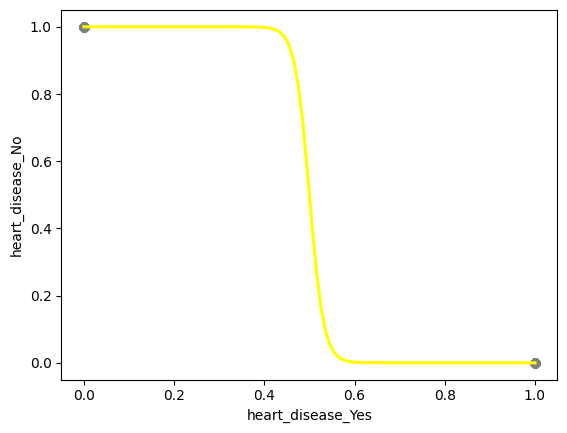

In [ ]:
#define the predictor variable and the response variable
x = encoded_df['heart_disease_Yes']
y = encoded_df['heart_disease_No']

#plot logistic regression curve
sns.regplot(x=x, y=y, data=encoded_df, logistic=True, ci=None, scatter_kws={'color': 'gray'}, line_kws={'color': 'yellow'})

# Model 2: Support Vector Machine

Support Vector Machine (SVM) algorithms are renound for being accurate but they can be difficult to design. In comparison with logisitic regression, SVG's are appropriate for large datasets and will be more accurate as they can employ a non-linear approach.

The below model will use SVM's for classification and will separate classes of the datapoints into a multi-dimentional space where each respective cluster will be separated by a hyperplane.

In [ ]:
# Initialise model and fit to the training data
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear')

In [ ]:
# Validate with the test data
svm_model.score(X_test, y_test)

0.7871132985134592

In the validation step, a small subset of the labeled data was used to test how well the model is able to predict labels. The above outcome suggests that the SVM model is able to correctly predict 78.71% (2.d.p) of all individuals in the test dataset (15,672 out of 19,912 individuals). This is a positive outcome. However, as human health is a highly sensitive topic with great importance, for this model to become respected, an accuracy of 99% or above would be ideal.

The 4,239 indivudals in the test dataset who would have been informed incorrectly would either not recieve the medication and life style change they need or would be unecessarily making these changes.

It should be noted that accuracy can be very suceptible to imbalanced classes. If the initial dataset brought into this script was trained against without taking a representitive sample and then oversampling the minority class, it would have been really easy for the model to only care about people without a cardiovascular disease because they would have had the biggest impact on accuracy. However, we also care about the people with a heart disease which highlights the importance of the step taken during preprocessing.

In [ ]:
# Save model's predicitons for the test data
training_predictions = svm_model.predict(X_test)

# Create a confusion matrix
training_matrix = confusion_matrix(y_test, training_predictions)

pd.DataFrame(training_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
Actual 0,10845,3068
Actual 1,1171,4828


The findings from the above confusion matrix are very insightful, it has informed that our SVM model has:
*   Correctly predicted 10,845 individuals who did not have heart disease.
*   Correctly predicted 4,828 individuals who did have heart disease.

However, what is of more value to be aware of is:
*   1,171 individuals who actually had heart disease were predicted as not having one by this model.
*   3,068 individuals who did not actually have heart disease were predicted as having one by this model.

The model seems to be more likely to predict someone who does not have heart disease as having one than the contary.

In [ ]:
# Target prediciton categories
target_names = ["No Heart Disease", "Heart Disease"]

# Print a classification report
print(classification_report(y_test, training_predictions,
                            target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.90      0.78      0.84     13913
   Heart Disease       0.61      0.80      0.69      5999

        accuracy                           0.79     19912
       macro avg       0.76      0.79      0.77     19912
    weighted avg       0.81      0.79      0.79     19912



Precision represents the ratio of correctly predicted positive observaions to the total predicted positive observations:
* The precision was 90% for No Heart Disease, suggesting that there is a low false positive rate
* The precision was 61% for Heart Disease, suggesting that the false positive rate was higher for those with a heart disease

Recall represents the ratio of positive obervations to all predicted observations of that class:
* The recall was 78% for No Heart Disease, suggesting that there is a low false negative rate for those without a heart disease
* The recall was 80% for Heart Disease, suggesting that the false negative rate was slightly lower for those with a heart disease

Considering the average of the precision and recall, the overall model has a f1 score of 79% which shows the model is fairly good at avoiding false negatives and positives but there is room for improvement before this model would be worthy to deal with such a sensitive topic due to the repercussions of these false positives and negatives which are still present.

# Model 3: Decision Tree

**The Decision Tree Classifie**r is a machine learning algorithm that creates a tree-like structure to make decisions based on **input features.** Each node in the tree represents a decision point based on a specific feature and a threshold value. The tree branches out into two or more child nodes based on the feature values, creating a hierarchical structure. The leaf nodes of the tree represent the predicted class labels.

It is known **simplicity and interpretability** and it is used for both classification and regression tasks.

**Model Creation**: In the code below, a Decision Tree Classifier is created with random_state=42. The random_state parameter ensures that the model's behavior remains consistent across runs for reproducibility.

In [ ]:
# Creating Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

**Model Training**: The model is trained using the training data (X_train_resampled and y_train_resampled) with the fit method. During training, the Decision Tree algorithm learns to make decisions by selecting the best features and thresholds that result in the most accurate predictions on the training data.

In [ ]:
# Fit the model to the training data
dt_model.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

**Making Predictions**: After training, the model is used to make predictions on the test dataset (X_test) with the predict method. The predicted labels are stored in the y_pred variable

In [ ]:
# Predicting on the test data
y_pred = dt_model.predict(X_test)

**Model Evaluation**:

**Accuracy:**
The accuracy_score function calculates accuracy, which is the proportion of correctly predicted samples in the test dataset. It's a commonly used metric for binary and multiclass classification tasks.

**Confusion Matrix:**
The confusion matrix, generated by the confusion_matrix function, provides a detailed view of the model's performance.
It consists of four components:
True Positives (TP): The number of correctly predicted positive samples.
True Negatives (TN): The number of correctly predicted negative samples.
False Positives (FP): The number of negative

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

**Results Printing**: The code then prints out the evaluation results, including accuracy, the confusion matrix, and the classification report.

*Classification Accuracy*: 0.8935 (approximately 89.35%)

This is the overall accuracy of the model, which represents the proportion of correctly predicted samples in the test dataset. In this case, it means that approximately 89.35% of the test samples were correctly classified by the model.

*The confusion matrix* provides a detailed breakdown of the model's predictions:
True Positives (TP): 5016 cases were correctly predicted as positive.
True Negatives (TN): 12776 cases were correctly predicted as negative.
False Positives (FP): 1137 cases were incorrectly predicted as positive (Type I error).
False Negatives (FN): 983 cases were incorrectly predicted as negative (Type II error).

*Precision (for class 0 and class 1):* Precision measures the proportion of true positive predictions out of all positive predictions. For class 0, it is approximately 0.93, and for class 1, it is approximately 0.82. This indicates that when the model predicts class 0, it is correct about 93% of the time, and when it predicts class 1, it is correct about 82% of the time.

*Recall (for class 0 and class 1):* Recall, also known as sensitivity, measures the proportion of true positive predictions out of all actual positives. For class 0, it is approximately 0.92, and for class 1, it is approximately 0.84. This indicates that the model correctly identifies about 92% of the actual class 0 samples and about 84% of the actual class 1 samples.

F1-Score (for class 0 and class 1): The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, it is approximately 0.92, and for class 1, it is approximately 0.83. Higher F1-scores indicate better performance in terms of both precision and recall.

Support (for class 0 and class 1): Support indicates the number of true instances for each class in the test dataset. There are 13,913 instances of class 0 and 5,999 instances of class 1 in the test data.

Macro Average: The macro average takes the average of precision, recall, and F1-score across all classes. In this case, it's approximately 0.87, indicating the overall performance across both classes.

Weighted Average: The weighted average considers the support (number of instances) for each class when calculating the average. It provides a more accurate representation of performance, considering class imbalances. In this case, it's approximately 0.89, reflecting the overall weighted performance across both classes.

In [ ]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8935315387705905
Confusion Matrix:
 [[12776  1137]
 [  983  5016]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     13913
           1       0.82      0.84      0.83      5999

    accuracy                           0.89     19912
   macro avg       0.87      0.88      0.87     19912
weighted avg       0.89      0.89      0.89     19912



# Model 4: Random Forest

**A Random Forest** is an ensemble learning method, which means it combines the predictions of multiple individual models to make more accurate predictions collectively. In this case, those individual models are decision trees.


The following hyperparameters were used:

*n_estimators=100*: This specifies the number of decision trees (estimators) in the ensemble. In this case, 100 decision trees are used.

*random_state=42*: The random state is set for reproducibility.

In [ ]:
# Create a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

The Random Forest model (rf) is trained on the training data using the fit method.

In [ ]:
# Fit the model to the training data
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Predictions are made on the test data using the predict method, and the predicted labels are stored in y_pred.

In [ ]:
# Predicting on the test data
y_pred = rf_model.predict(X_test)

**Classification Report**: The Random Forest Classifier achieved an accuracy of approximately 92.80%, which indicates that about 92.80% of the test samples were correctly classified.

The confusion matrix shows that the model correctly predicted 13,557 instances of class 0 (True Negatives) and 4,922 instances of class 1 (True Positives).
It had 356 False Positives (predicting class 1 when it was actually class 0) and 1,077 False Negatives (predicting class 0 when it was actually class 1).

For class 0 (no heart disease), the model achieved a precision of 0.93 and recall of 0.97. This means it correctly predicted 93% of the instances as class 0 out of all instances it predicted as class 0, and it captured 97% of the actual class 0 instances.
For class 1 (heart disease), the model achieved a precision of 0.93 and recall of 0.82, indicating that it correctly predicted 93% of the instances as class 1 out of all instances it predicted as class 1, and it captured 82% of the actual class 1 instances.
Additional Information:

The macro average F1-score is approximately 0.91, indicating strong overall performance across both classes.
The weighted average F1-score is approximately 0.93, reflecting the overall weighted performance across both classes, considering class imbalances.

In [ ]:
# Evaluate the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9280333467255926
Confusion Matrix:
 [[13557   356]
 [ 1077  4922]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     13913
           1       0.93      0.82      0.87      5999

    accuracy                           0.93     19912
   macro avg       0.93      0.90      0.91     19912
weighted avg       0.93      0.93      0.93     19912



The Random Forest Classifier for **feature importance** provides a method to assess the significance of each feature (ie. general heath and several food consumptions) in predicting the target variable (in this case, the presence of cardiovascular disease) based on the ensemble of decision trees.


In [ ]:
# Calculate feature importance
feature_importance = rf_model.feature_importances_

In [ ]:
# Create a DataFrame to associate feature names with their importance scores
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

In [ ]:
# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Print or visualize the feature importance
print(importance_df)

                            Feature  Importance
0                         height_cm    0.168849
4                 fruit_consumption    0.155208
2                               bmi    0.103543
1                         weight_kg    0.102074
3               alcohol_consumption    0.069646
6           friedpotato_consumption    0.058505
5      green_vegetables_consumption    0.054695
27                     arthritis_No    0.020196
26                     diabetes_Yes    0.020141
43                 age_category_80+    0.019500
25                      diabetes_No    0.018765
8               general_health_Fair    0.018438
28                    arthritis_Yes    0.013832
10              general_health_Poor    0.012223
11         general_health_Very Good    0.011168
7          general_health_Excellent    0.010467
29                       sex_Female    0.010109
30                         sex_Male    0.009722
42               age_category_75-79    0.009370
44               smoking_history_No    0

The top three important features for predicting cardiovascular disease (CVD) are identified as height, fruit consumption, and BMI (Body Mass Index).



In [ ]:
# Display only the top N most important features
top_n = 10
top_importance_df = importance_df.head(top_n)

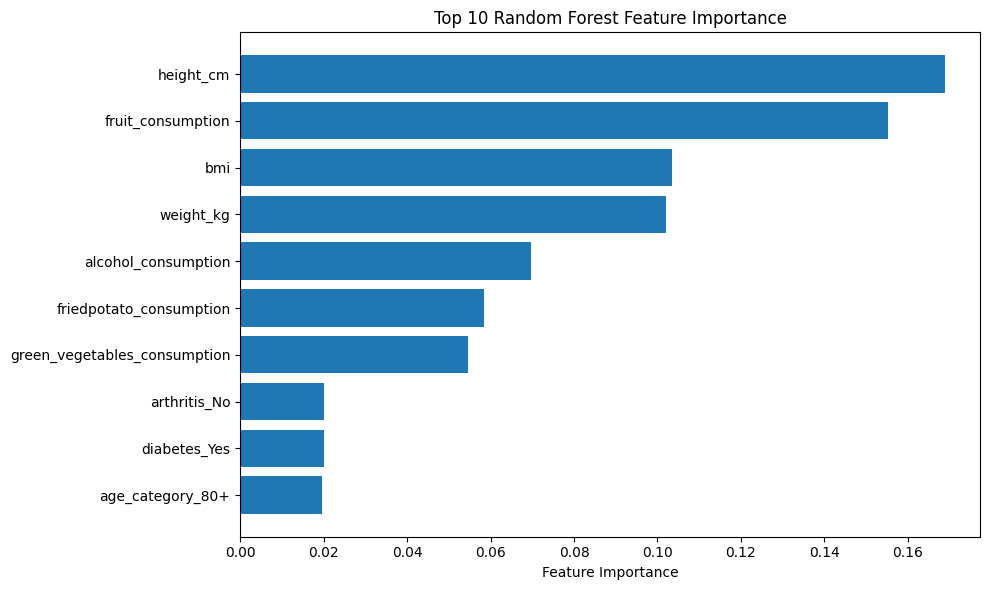

In [ ]:
# Plot the feature importance
y_pos = range(len(top_importance_df))
plt.figure(figsize=(10, 6))
plt.barh(y_pos, top_importance_df['Importance'])
plt.yticks(y_pos, top_importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top {} Random Forest Feature Importance'.format(top_n))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

While the feature importance analysis provides valuable insights, several important considerations highlight the need for further investigation:

1. Correlation vs. Causation: **Feature importance does not establish causation.** While height, fruit consumption, and BMI may be important predictors, they may not be the direct causes of CVD.

2. Domain Expertise: Medical and domain experts should validate the findings. They can provide insights into the biological and clinical relevance of these features and their relationships with CVD.

3. Data Quality: The results are based on the quality and representativeness of the dataset.



# Model 5: Neural Network

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train_resampled.shape[1]
hidden_nodes_layer1 =  64
hidden_nodes_layer2 = 64

nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3008      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7233 (28.25 KB)
Trainable params: 7233 (28.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn_model.fit(X_train_resampled, y_train_resampled, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
2604/2604 [==============================] - 9s 3ms/step - loss: 0.3079 - accuracy: 0.8594 - val_loss: 0.2551 - val_accuracy: 0.8902
Epoch 2/100
2604/2604 [==============================] - 11s 4ms/step - loss: 0.2726 - accuracy: 0.8732 - val_loss: 0.2388 - val_accuracy: 0.8969
Epoch 3/100
2604/2604 [==============================] - 6s 2ms/step - loss: 0.2567 - accuracy: 0.8819 - val_loss: 0.2383 - val_accuracy: 0.9041
Epoch 4/100
2604/2604 [==============================] - 7s 3ms/step - loss: 0.2443 - accuracy: 0.8871 - val_loss: 0.2568 - val_accuracy: 0.8803
Epoch 5/100
2604/2604 [==============================] - 6s 2ms/step - loss: 0.2361 - accuracy: 0.8905 - val_loss: 0.2257 - val_accuracy: 0.9070
Epoch 6/100
2604/2604 [==============================] - 7s 3ms/step - loss: 0.2312 - accuracy: 0.8919 - val_loss: 0.2265 - val_accuracy: 0.9062
Epoch 7/100
2604/2604 [==============================] - 6s 2ms/step - loss: 0.2260 - accuracy: 0.8951 - val_loss: 0.2136 - val_a

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

623/623 - 1s - loss: 0.4548 - accuracy: 0.8780 - 731ms/epoch - 1ms/step
Loss: 0.45480450987815857, Accuracy: 0.8780132532119751


As the number of epochs increases, the training accuracy increases and the training loss decreases indicating that the model is learning well on the training data. However, after around 20 epochs we see that the validation accuracy plateaus and starts to decrease, and the validation loss appears to increase. This suggests that the model is overfitting and though it performs well on the training data, it may struggle on unseen data.

In [ ]:
# Make predictions using the trained model
# Setting threshold of 0.5 since our model utilises sigmoid activation on a binary classification problem
y_pred = (nn_model.predict(X_test) > 0.5).astype(np.int32)

# Print the classification report
print(classification_report(y_test, y_pred))

623/623 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     13913
           1       0.78      0.83      0.80      5999

    accuracy                           0.88     19912
   macro avg       0.85      0.86      0.86     19912
weighted avg       0.88      0.88      0.88     19912



- For class 0 (no heart disease), a precision of 0.92 means that when the model predicts 'no heart disease,' it is correct 92% of the time. This suggests only 8% of 'no heart disease' predictions are incorrect. A recall of 0.90 means that out of all the actual 'no heart disease' cases, the model correctly identified 90% of them.
- For class 1 (heart disease), a precision of 0.78 means that when the model predicts 'heart disease,' it is correct 78% of the time. A recall of 0.83 means that out of all the actual 'heart disease' cases, the model correctly identified 83% of them. This indicates that the model missed 17% of the 'heart disease' cases.
- The overall accuracy of this model is 88% which is reasonably good, though there is room for improvement, especially in predicting positive instances of heart disease.

In [ ]:
# Download h5 file
nn_model.save('cvd_nn_model1.h5')
files.download("cvd_nn_model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Comparison

In [ ]:
# Store each prediction model's accuracy and precision scores in a dictionary
scores = {
   'Model': ['Random Forests', 'Decision Tree', 'Neural Network', 'Logistic Regression', 'SVM'],
   'Accuracy': [0.93, 0.89, 0.88, 0.82, 0.79],
   'Precision': [0.93, 0.89, 0.88, 0.81, 0.81]
}

# Convert dicitonary to a DataFrame
comparison_df = pd.DataFrame(scores)

# Define colors codes for the bars
colors = ['#FF6961', '#DEA5A4']

# Create a grouped bar chart with Accuracy and Precision
fig = go.Figure(data=[
                      go.Bar(name='Accuracy', x=comparison_df['Model'], y=comparison_df['Accuracy'], marker_color=colors[0]),
                      go.Bar(name='Precision', x=comparison_df['Model'], y=comparison_df['Precision'], marker_color=colors[1])
                    ])

# Chart layout
fig.update_layout(
                  barmode='group',
                  title=dict(text='Machine Learning Model Performance Comparison', font=dict(color='black')),
                  xaxis=dict(tickfont=dict(color='black')),
                  yaxis=dict(tickfont=dict(color='black')),
                  xaxis_title=dict(text='Model', font=dict(color='black')),
                  yaxis_title=dict(text='Score', font=dict(color='black')),
                  legend=dict(font=dict(color='black')),
                  template='simple_white',
                  )

# Add interactivity for toggling between Accuracy, Precision, and both
fig.update_layout(
                  updatemenus=[
                               {
                                'buttons': [
                                            {
                                             'label': 'Accuracy and Precision',
                                             'method': 'update',
                                             'args': [{'visible': [True, True]}, {'title': 'Both Accuracy and Precision'}]
                                            },
                                            {
                                             'label': 'Accuracy',
                                             'method': 'update',
                                             'args': [{'visible': [True, False]}, {'title': 'Accuracy Comparison'}]
                                            },
                                            {
                                            'label': 'Precision',
                                            'method': 'update',
                                            'args': [{'visible': [False, True]}, {'title': 'Precision Comparison'}]
                                            },
                                          ],
                             'direction': 'down',
                             'showactive': True,
                             }
                            ]
                )

# Show the chart
fig.show()